<a href="https://colab.research.google.com/github/cbarlow-corelationinc/python_covid/blob/main/COVID_19_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing COVID-19 Data

-----

A time series data is a series of data points indexed in time order, often with equal intervals between indexes. In this notebook, we use data related to the case count of COVID-19 in the U.S. to show how to work efficiently with time series data in Python, by using the Pandas library.

-----

## Table of Contents


[Data](#Data)

[Plot Time Series](#Plot-Time-Series)

-----

Before proceeding with the rest of this notebook, we first include the notebook setup code.

-----

In [1]:
# Set up Notebook

%matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# These two lines suppress warnings that sometimes
# occur when making visualizations
import warnings
warnings.filterwarnings('ignore')

# Set global figure properties
import matplotlib as mpl
mpl.rcParams.update({'axes.titlesize' : 20,
                     'axes.labelsize' : 18,
                     'legend.fontsize': 16})

# Set default Seaborn plotting style
sns.set_style('white')

# Extra imports
from datetime import datetime
import requests, zipfile, io

-----

[[Back to TOC]](#Table-of-Contents)

## Data

We will load a new data set into our notebook. This data contains fips*, total number of diagnosed cases of COVID-19, and total number of deaths attributed to COVID-19, broken out by date and state. The dataset comes from  [New York Times COVID-19 Data](https://github.com/nytimes/covid-19-data).


In the next Code cell, we first load the datasets and display five sample rows in the us-states dataset. 

*The 'fips' column includes the ANSI Federal Information Processing Standards (FIPS) Code for a geographic entity like a state or county. This standard geographic identifier makes it easier for an analyst to combine this data with other data sets like a map file or population data.

In [2]:
#!wget -q https://github.com/cbarlow-corelationinc/python_covid/blob/main/data.zip?raw=true
r = requests.get( 'https://github.com/cbarlow-corelationinc/python_covid/blob/main/data.zip?raw=true') 
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()
!ls -Abl

total 12
drwxr-xr-x 1 root root 4096 Feb  1 17:27 .config
drwxr-xr-x 2 root root 4096 Feb  3 21:38 data
drwxr-xr-x 1 root root 4096 Feb  1 17:27 sample_data


In [3]:
# Load local data file
df_us = pd.read_csv('data/us.csv')
df_states = pd.read_csv('data/us-states.csv')
df_counties = pd.read_csv('data/us-counties.csv')
df_states.sample(5)

,date,state,fips,cases,deaths
14206,2020-11-16,Arizona,4,277179,6302
8317,2020-07-31,Wisconsin,55,57020,943
8151,2020-07-28,West Virginia,54,6173,111
9334,2020-08-19,Mississippi,28,74555,2163
14904,2020-11-28,Pennsylvania,42,356243,10337


-----

To work with time data by using Pandas, it is more efficient to have a time stamp index. We create this new index in the next few Code cells. 

First, we generate a new time stamp feature, called `TS`, that converts the `date` features of each row into a datetime object.  

Next, to analyze time series data, we need a datetime index. In this dataset, we use the new `TS` feature to create  the datetime index. We call Pandas `DatetimeIndex` function to create a datetime index from `TS`, then set it as the DataFrame's index.

Then, we display several observations at random, indicating the extra columns. 

Next, we drop these extra columns, creating a compact DataFrame with the datetime index and features of interest, `state`, `fips`, `cases`, and `deaths`.

Finally, we display the basic information of the states dataset. The dataset has total 3919 observations as of May 12, 2020. There are no missing values in any of the feature columns, so we will not need to take measures such as dropping rows with null values or filling them in with mean values or interpolated values, etc. 

-----

In [4]:
# Build Timestamp Feature
df_us['TS'] = pd.to_datetime(df_us.date)
df_states['TS'] = pd.to_datetime(df_states.date)
df_counties['TS'] = pd.to_datetime(df_counties.date)
df_states.tail()

,date,state,fips,cases,deaths,TS
18544,2021-02-02,Virginia,51,510380,6517,2021-02-02
18545,2021-02-02,Washington,53,318967,4402,2021-02-02
18546,2021-02-02,West Virginia,54,121935,2031,2021-02-02
18547,2021-02-02,Wisconsin,55,594217,6485,2021-02-02
18548,2021-02-02,Wyoming,56,52128,624,2021-02-02


In [5]:
# Convert TS to DataFrame Index
df_us.index = pd.DatetimeIndex(df_us.TS)
df_states.index = pd.DatetimeIndex(df_states.TS)
df_counties.index = pd.DatetimeIndex(df_counties.TS)
# Index works, but extra columns
df_states.sample(5)

,date,state,fips,cases,deaths,TS
TS,,,,,,
2020-07-07,2020-07-07,Oregon,41,10654,224,2020-07-07
2020-10-25,2020-10-25,California,6,909344,17358,2020-10-25
2020-04-02,2020-04-02,Wisconsin,55,1730,37,2020-04-02
2020-12-19,2020-12-19,Maine,23,18739,292,2020-12-19
2020-10-01,2020-10-01,Massachusetts,25,132870,9480,2020-10-01


In [6]:
# Remove extra columns
df_us.drop(['date', 'TS'], axis=1, inplace=True)
df_states.drop(['date', 'TS'], axis=1, inplace=True)
df_counties.drop(['date', 'TS'], axis=1, inplace=True)
# We now have a compact DataFrame
df_states.sample(5)

,state,fips,cases,deaths
TS,,,,
2020-11-27,New York,36,633140,34004
2021-01-19,Ohio,39,836055,10336
2020-09-16,Illinois,17,269282,8622
2020-09-02,Vermont,50,1637,58
2020-04-16,South Carolina,45,3931,109


In [7]:
df_states.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18549 entries, 2020-01-21 to 2021-02-02
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   state   18549 non-null  object
 1   fips    18549 non-null  int64 
 2   cases   18549 non-null  int64 
 3   deaths  18549 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 724.6+ KB


Now let's make a new Pandas dataframe df_nc from the states dataset that only includes data where the state column is 'North Carolina' and let's create a dataframe df_meck from the counties dataset that only includes data where the state column is 'North Carolina' and the county column is 'Mecklenburg'. While we're at it, let's create two new columns `new_cases` and `new_deaths` in the dataframes df_us, df_nc, and df_meck that list the _changes_ in cases and deaths from the previous day. We can use the diff() function for a Series or DataFrame to calculate these daily differences.

In [8]:
# Make new columns for new cases and new deaths
df_us = pd.concat([df_us, df_us['cases'].diff().rename('new_cases')], axis=1)
df_us = pd.concat([df_us, df_us['deaths'].diff().rename('new_deaths')], axis=1)

# Make dataframe for North Carolina 
df_nc = df_states[df_states.state=='North Carolina']
df_nc = pd.concat([df_nc, df_nc['cases'].diff().rename('new_cases')], axis=1)
df_nc = pd.concat([df_nc, df_nc['deaths'].diff().rename('new_deaths')], axis=1)
df_nc.tail()

# Make dataframe for Mecklenburg County, NC 
df_meck = df_counties[(df_counties.state=='North Carolina') & (df_counties.county=='Mecklenburg')]
df_meck = pd.concat([df_meck, df_meck['cases'].diff().rename('new_cases')], axis=1)
df_meck = pd.concat([df_meck, df_meck['deaths'].diff().rename('new_deaths')], axis=1)
#df_meck.tail()

-----

[[Back to TOC]](#Table-of-Contents)

## Plot Time Series

Pandas provides considerable functionality to work with time series data. The following Code cell demonstrates how easy it can be to plot time series data by using Pandas. We directly call `plot` function from `cases` column for the U.S. dataset. The function will automatically use the datetime index as x axis. It's smart enough to only use month as x tick value. 

In the `plot` function, we can optionally pass two arguments, `lw` which defines the line width of the plot, and `alpha`, which defines the transparency of the plotting line. 

In subsequent Code cells, we also plot new cases in the U.S., along with a rolling 14-day average, and total and new cases in North Carolina and in Mecklenburg County.

-----

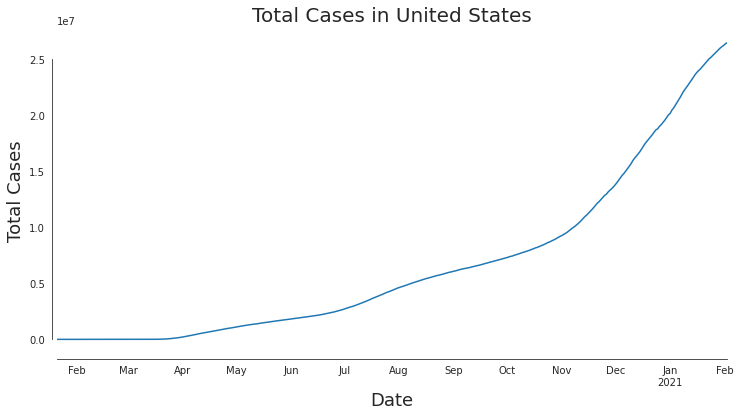

In [9]:
# Plot total cases for Country
fig, ax = plt.subplots(figsize=(12, 6))
df_us.cases.plot()

ax.set(title='Total Cases in United States',
      xlabel='Date', ylabel = 'Total Cases')

sns.despine(offset=5, trim=True)

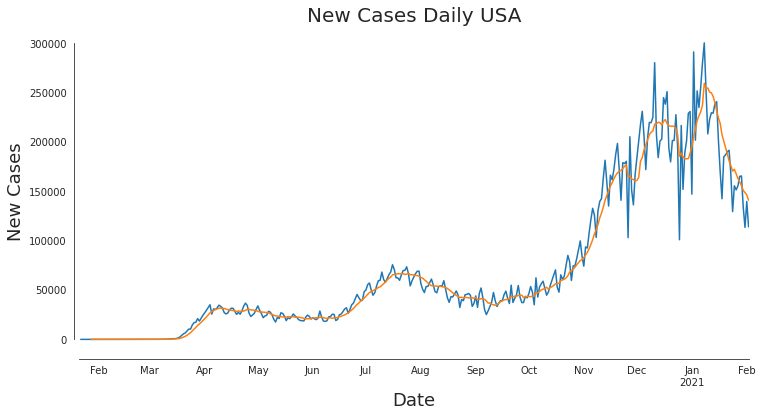

In [10]:
roll7_df = df_us['new_cases'].rolling(7)
fig, ax = plt.subplots(figsize=(12, 6))
df_us.new_cases.plot(label='Data')
roll7_df.mean().plot(label='7 day moving average')

ax.set(title='New Cases Daily USA',
      xlabel='Date', ylabel = 'New Cases')

sns.despine(offset=5, trim=True)

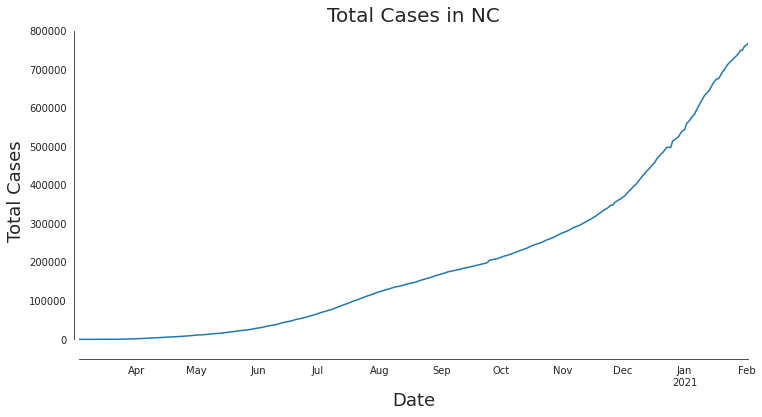

In [11]:
# Plot total cases for North Carolina 
fig, ax = plt.subplots(figsize=(12, 6))
#df_nc.cases.plot(lw=0.1, alpha=0.5)
df_nc.cases.plot()

ax.set(title='Total Cases in NC',
      xlabel='Date', ylabel = 'Total Cases')

sns.despine(offset=5, trim=True)

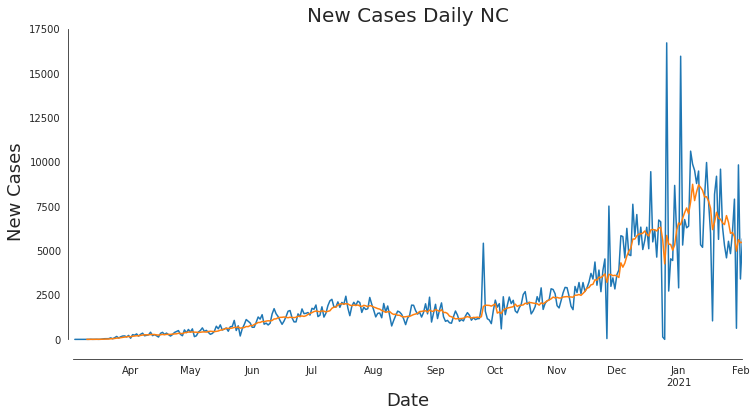

In [12]:
roll7_df = df_nc['new_cases'].rolling(7)
fig, ax = plt.subplots(figsize=(12, 6))
df_nc.new_cases.plot(label='Data')
roll7_df.mean().plot(label='7 day moving average')

ax.set(title='New Cases Daily NC',
      xlabel='Date', ylabel = 'New Cases')

sns.despine(offset=5, trim=True)

In [13]:
df_nc.tail(20)

,state,fips,cases,deaths,new_cases,new_deaths
TS,,,,,,
2021-01-14,North Carolina,37,651533,7888,8013.0,92.0
2021-01-15,North Carolina,37,661506,7996,9973.0,108.0
2021-01-16,North Carolina,37,669284,8060,7778.0,64.0
2021-01-17,North Carolina,37,675272,8125,5988.0,65.0
2021-01-18,North Carolina,37,676315,8131,1043.0,6.0
2021-01-19,North Carolina,37,684497,8196,8182.0,65.0
2021-01-20,North Carolina,37,693695,8267,9198.0,71.0
2021-01-21,North Carolina,37,699334,8397,5639.0,130.0
2021-01-22,North Carolina,37,708931,8511,9597.0,114.0


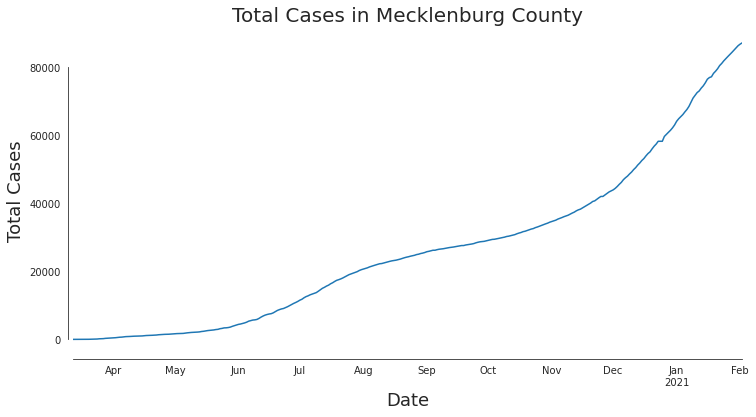

In [14]:
# Plot total cases for Mecklenburg County 
fig, ax = plt.subplots(figsize=(12, 6))
df_meck.cases.plot()

ax.set(title='Total Cases in Mecklenburg County',
      xlabel='Date', ylabel = 'Total Cases')

sns.despine(offset=5, trim=True)

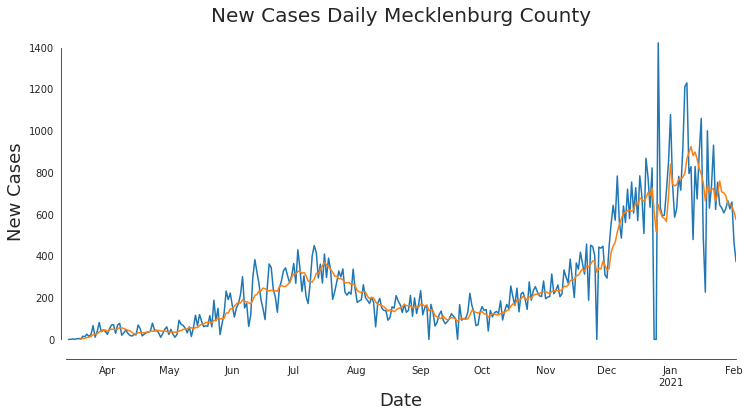

In [15]:
roll7_df = df_meck['new_cases'].rolling(7)
fig, ax = plt.subplots(figsize=(12, 6))
df_meck.new_cases.plot(label='Data')
roll7_df.mean().plot(label='7 day moving average')

ax.set(title='New Cases Daily Mecklenburg County',
      xlabel='Date', ylabel = 'New Cases')

sns.despine(offset=5, trim=True)

We can also analyze the deaths over time in Mecklenburg County. First we can just see the raw data for the last ten days. Then we plot the total deaths over time. Finally, we list all rows in the Mecklenburg data set that have a new_deaths value greater than 0. This shows the data for every date in which there was at least one death in the county.

In [16]:
df_meck.tail(10)

,county,state,fips,cases,deaths,new_cases,new_deaths
TS,,,,,,,
2021-01-24,Mecklenburg,North Carolina,37119.0,81933,739.0,754.0,13.0
2021-01-25,Mecklenburg,North Carolina,37119.0,82578,747.0,645.0,8.0
2021-01-26,Mecklenburg,North Carolina,37119.0,83209,754.0,631.0,7.0
2021-01-27,Mecklenburg,North Carolina,37119.0,83816,756.0,607.0,2.0
2021-01-28,Mecklenburg,North Carolina,37119.0,84444,766.0,628.0,10.0
2021-01-29,Mecklenburg,North Carolina,37119.0,85109,770.0,665.0,4.0
2021-01-30,Mecklenburg,North Carolina,37119.0,85735,770.0,626.0,0.0
2021-01-31,Mecklenburg,North Carolina,37119.0,86394,777.0,659.0,7.0
2021-02-01,Mecklenburg,North Carolina,37119.0,86860,786.0,466.0,9.0


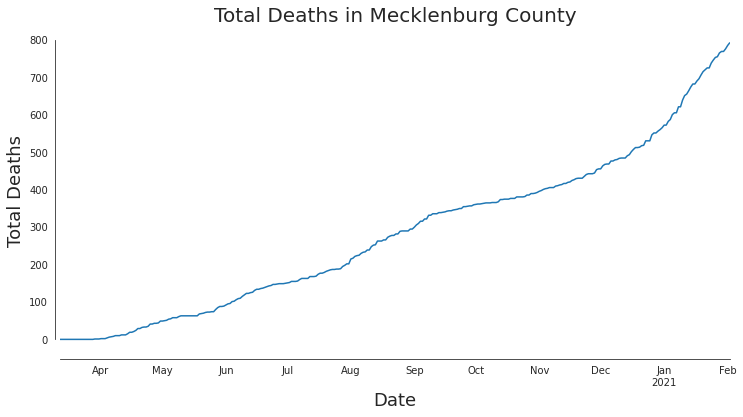

In [17]:
# Plot total deaths for Mecklenburg County 
fig, ax = plt.subplots(figsize=(12, 6))
df_meck.deaths.plot()

ax.set(title='Total Deaths in Mecklenburg County',
      xlabel='Date', ylabel = 'Total Deaths')

sns.despine(offset=5, trim=True)

In [18]:
df_meck[df_meck.new_deaths>0]

,county,state,fips,cases,deaths,new_cases,new_deaths
TS,,,,,,,
2020-03-29,Mecklenburg,North Carolina,37119.0,336,1.0,37.0,1.0
2020-04-01,Mecklenburg,North Carolina,37119.0,444,2.0,24.0,1.0
2020-04-04,Mecklenburg,North Carolina,37119.0,635,4.0,71.0,2.0
2020-04-05,Mecklenburg,North Carolina,37119.0,664,6.0,29.0,2.0
2020-04-06,Mecklenburg,North Carolina,37119.0,733,7.0,69.0,1.0
...,...,...,...,...,...,...,...
2021-01-28,Mecklenburg,North Carolina,37119.0,84444,766.0,628.0,10.0
2021-01-29,Mecklenburg,North Carolina,37119.0,85109,770.0,665.0,4.0
2021-01-31,Mecklenburg,North Carolina,37119.0,86394,777.0,659.0,7.0


The following is a test of the [Plotly Python Graphing Library](https://plotly.com/python/)--an alternative to matplotlib and seaborn (note how the line graph supports rollover tooltips).

In [19]:
# Using graph_objects
import plotly.graph_objects as go

# plotly seems to have trouble using the actul TS timestamp index as the x. Could have used
# the original date column we deleted several steps ago.fig = go.Figure()
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_meck.index.to_pydatetime(), y=df_meck['new_cases'],
                    mode='lines',
                    name='new cases'))
fig.add_trace(go.Scatter(x=df_meck.index.to_pydatetime(), y=df_meck['new_cases'].rolling(7).mean(),
                    mode='lines',
                    name='rolling 7 day mean'))
fig.show()

## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

1. Introduction to [working with time series data][pat] by using Pandas
2. Worked example of using [Pandas for time series analysis][pate]
2. Analyzing stock data with [Pandas][nbta]
3. [Financial analysis][fapt] by using Pandas
3. [Financial analysis with Google trends][fapt2] by using Pandas
4. [Time series plots][tspp] by using Python
5. Somewhat dated discussion of using Pandas for [time series analysis][pbts]
5. [Using Pandas for time series analysis][pt]

-----

[pat]: http://www.vincentgregoire.com/introduction-to-pandas/

[pate]: http://www.vincentgregoire.com/crsp-example-dividends/

[nbta]: http://nbviewer.jupyter.org/github/jdwittenauer/ipython-notebooks/blob/master/notebooks/misc/TimeSeriesStockAnalysis.ipynb

[fapt]: https://github.com/twiecki/financial-analysis-python-tutorial/blob/master/1.%20Pandas%20Basics.ipynb

[fapt2]: https://github.com/twiecki/financial-analysis-python-tutorial/blob/master/2.%20Pandas%20replication%20of%20Google%20Trends%20paper.ipynb

[tspp]: http://www.blackarbs.com/blog/advanced-time-series-plots-in-python/1/6/2017

[pbts]: http://earthpy.org/pandas-basics.html

[pt]: http://www.marcelscharth.com/python/time.html

[tspr]: http://connor-johnson.com/2014/11/23/time-series-forecasting-in-python-and-r/

[tsd]: https://www.bundesbank.de/Navigation/EN/Statistics/Time_series_databases/Real_Time_Data/realtime_list_node.html?listId=rt_s311_m.de.n.i.io1.acm03.c.i
[tsf]:https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000

**&copy; 2020: Corelation, Inc.**